In [23]:
import chess
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from read_pgn import process_pgn_file
from read_pgn import extract_board_features

Data is from July 2014 with over 1 million games.

In [ ]:
# load the first 1,000,000 games for now
games_data = process_pgn_file('lichess_db_standard_rated_2014-07.pgn', target_move=20, max_games=1000000)

In [4]:
df = pd.DataFrame(games_data)
df.head()

,white_material,black_material,material_diff,white_pawns,black_pawns,white_knights,black_knights,white_bishops,black_bishops,white_rooks,...,black_king_attackers,to_move,legal_moves,is_check,is_checkmate,is_stalemate,white_elo,black_elo,elo_diff,result
0,31,29,2,6,7,1,0,1,1,2,...,0,1,40,0,0,0,1525,1458,67,0.0
1,28,28,0,6,6,0,0,1,1,2,...,0,1,32,0,0,0,1467,1314,153,1.0
2,21,29,-8,5,4,1,1,1,1,2,...,0,1,27,0,0,0,1445,1497,-52,0.0
3,29,29,0,4,7,0,0,2,1,2,...,0,1,5,1,0,0,1752,1698,54,1.0
4,29,22,7,7,5,0,0,1,1,2,...,0,1,32,0,0,0,1451,1415,36,1.0


In [27]:
# save to csv for faster future use
df.to_csv('lichess-2014-07.csv', index=False)

Visualize a random chess game to see how the feature engineering works.

Game 101:
White: PuffBijan (998)
Black: Ramil82 (1432)
Result: 0-1
Position after move 20:

Moves played:
1. e4 e5
2. Nf3 Nc6
3. Nc3 Nf6
4. Bc4 Bc5
5. g4 Nxg4
6. Ng5 Qxg5
7. h3 Nxf2
8. Qf3 Qf6
9. Rf1 O-O
10. Qg4 Nxg4
11. Rxf6 Nxf6
12. d3 d6
13. Nb5 Bb6
14. Bg5 Nh5
15. O-O-O a6
16. Nc3 Bxh3
17. Rh1 Bg4
18. Nd5 Ng3
19. b3 Nxh1

Position features:
Material - White: 14, Black: 30 (diff: -16)
Piece counts:
  Pawns - White: 5, Black: 8
  Knights - White: 1, Black: 2
  Bishops - White: 2, Black: 2
  Rooks - White: 0, Black: 2
  Queens - White: 0, Black: 0
King safety:
  White king attackers: 0
  Black king attackers: 0
Mobility:
  Legal moves: 26
  To move: White
Game state:
  Check: False
  Checkmate: False
  Stalemate: False



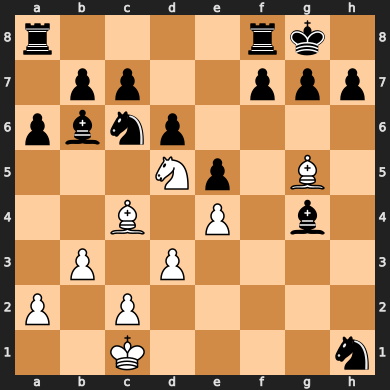

In [ ]:
from IPython.display import SVG, display
import chess.svg

def visualize_game_position(filename, game_index=0, target_move=20):
    """Get and visualize a chess position from a specific game"""
    with open(filename, 'r') as f:
        games_processed = 0
        
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
                
            if games_processed == game_index:
                # Get game info
                white_player = game.headers.get("White", "Unknown")
                black_player = game.headers.get("Black", "Unknown") 
                white_elo = game.headers.get("WhiteElo", "?")
                black_elo = game.headers.get("BlackElo", "?")
                result = game.headers.get("Result", "*")
                
                print(f"Game {game_index + 1}:")
                print(f"White: {white_player} ({white_elo})")
                print(f"Black: {black_player} ({black_elo})")
                print(f"Result: {result}")
                print(f"Position after move {target_move}:")
                print()
                
                # Play through to target move
                board = game.board()
                move_count = 0
                moves_played = []
                
                for move in game.mainline_moves():
                    if move_count >= target_move * 2:
                        break
                    moves_played.append(board.san(move))
                    board.push(move)
                    move_count += 1
                
                # Print the moves leading to this position
                print("Moves played:")
                for i in range(0, len(moves_played), 2):
                    move_num = (i // 2) + 1
                    white_move = moves_played[i] if i < len(moves_played) else ""
                    black_move = moves_played[i+1] if i+1 < len(moves_played) else ""
                    print(f"{move_num}. {white_move} {black_move}")
                print()
                
                # Extract and display features
                features = extract_board_features(board)
                print("Position features:")
                print(f"Material - White: {features['white_material']}, Black: {features['black_material']} (diff: {features['material_diff']})")
                print(f"Piece counts:")
                print(f"  Pawns - White: {features['white_pawns']}, Black: {features['black_pawns']}")
                print(f"  Knights - White: {features['white_knights']}, Black: {features['black_knights']}")
                print(f"  Bishops - White: {features['white_bishops']}, Black: {features['black_bishops']}")
                print(f"  Rooks - White: {features['white_rooks']}, Black: {features['black_rooks']}")
                print(f"  Queens - White: {features['white_queens']}, Black: {features['black_queens']}")
                print(f"King safety:")
                print(f"  White king attackers: {features['white_king_attackers']}")
                print(f"  Black king attackers: {features['black_king_attackers']}")
                print(f"  Black king pawn shield: {features['white_pawn_shield']}")
                print(f"  Black king pawn shield: {features['black_pawn_shield']}")
                print(f"Mobility:")
                print(f"  Legal moves: {features['legal_moves']}")
                print(f"  To move: {'White' if features['to_move'] else 'Black'}")
                print(f"Game state:")
                print(f"  Check: {bool(features['is_check'])}")
                print(f"  Checkmate: {bool(features['is_checkmate'])}")
                print(f"  Stalemate: {bool(features['is_stalemate'])}")
                print()
                
                # Create SVG visualization
                svg = chess.svg.board(board=board)
                display(SVG(svg))
                
                return game, board, features
            
            games_processed += 1
            
    return None, None, None

# Visualize a position
game1, board1, features1 = visualize_game_position('lichess_db_standard_rated_2014-07.pgn', game_index=100, target_move=20)

# Baseline Model: Regression on Rating Difference

In [2]:
df = pd.read_csv('lichess-2014-07.csv')
df.head()

,white_material,black_material,material_diff,white_pawns,black_pawns,white_knights,black_knights,white_bishops,black_bishops,white_rooks,...,black_king_attackers,to_move,legal_moves,is_check,is_checkmate,is_stalemate,white_elo,black_elo,elo_diff,result
0,31,29,2,6,7,1,0,1,1,2,...,0,1,40,0,0,0,1525,1458,67,0.0
1,28,28,0,6,6,0,0,1,1,2,...,0,1,32,0,0,0,1467,1314,153,1.0
2,21,29,-8,5,4,1,1,1,1,2,...,0,1,27,0,0,0,1445,1497,-52,0.0
3,29,29,0,4,7,0,0,2,1,2,...,0,1,5,1,0,0,1752,1698,54,1.0
4,29,22,7,7,5,0,0,1,1,2,...,0,1,32,0,0,0,1451,1415,36,1.0


In [3]:
X = df[['elo_diff']]
y = df['result']

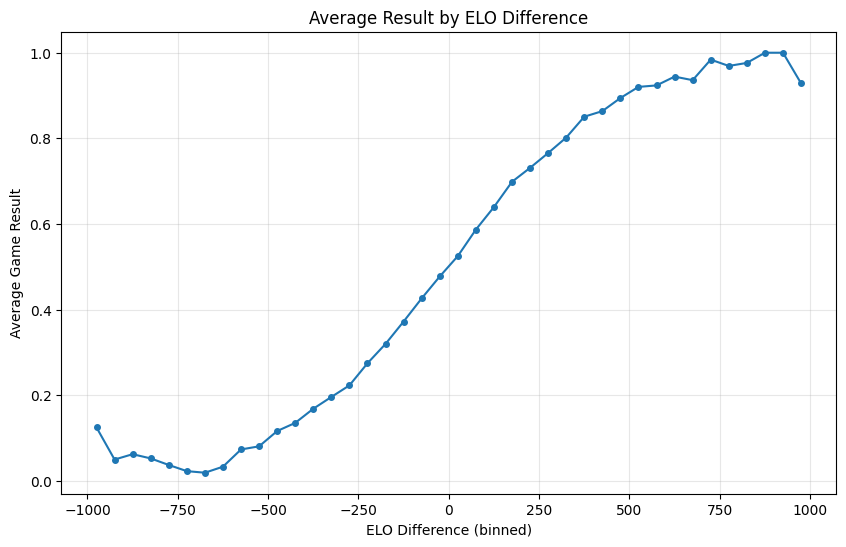

In [4]:
# 1. Binned average results
elo_bins = np.arange(-1000, 1001, 50)
bin_centers = (elo_bins[:-1] + elo_bins[1:]) / 2
binned_results = []

for i in range(len(elo_bins)-1):
    mask = (X['elo_diff'] >= elo_bins[i]) & (X['elo_diff'] < elo_bins[i+1])
    if mask.sum() > 0:
        binned_results.append(y[mask].mean())
    else:
        binned_results.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot(bin_centers, binned_results, 'o-', markersize=4)
plt.xlabel('ELO Difference (binned)')
plt.ylabel('Average Game Result')
plt.title('Average Result by ELO Difference')
plt.grid(True, alpha=0.3)
plt.show()

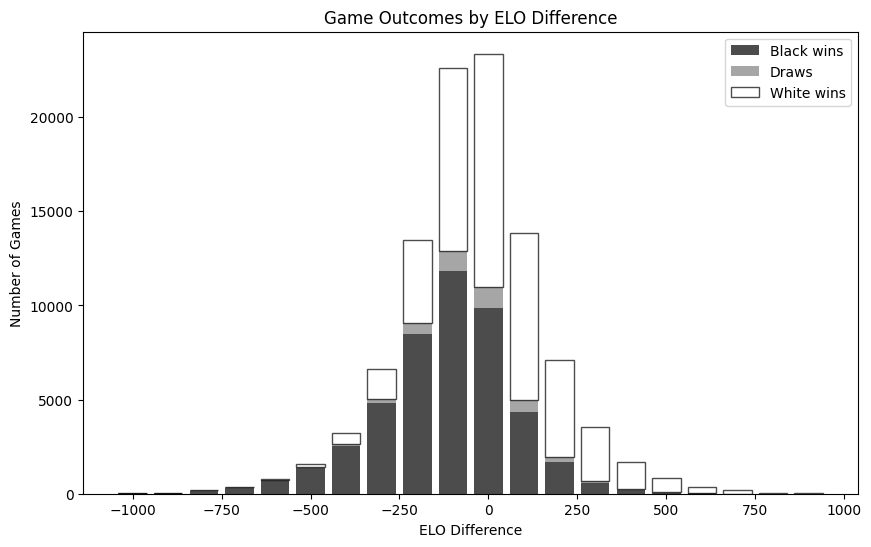

In [5]:
# 2. Stack histogram
elo_ranges = np.arange(-1000, 1001, 100)
black_wins = []
draws = []
white_wins = []

for i in range(len(elo_ranges)-1):
    mask = (X['elo_diff'] >= elo_ranges[i]) & (X['elo_diff'] < elo_ranges[i+1])
    subset = y[mask]
    black_wins.append((subset == 0).sum())
    draws.append((subset == 0.5).sum())
    white_wins.append((subset == 1).sum())

width = 80
plt.figure(figsize=(10, 6))
plt.bar(elo_ranges[:-1], black_wins, width, label='Black wins', color='black', alpha=0.7)
plt.bar(elo_ranges[:-1], draws, width, bottom=black_wins, label='Draws', color='gray', alpha=0.7)
plt.bar(elo_ranges[:-1], white_wins, width, bottom=np.array(black_wins)+np.array(draws), 
              label='White wins', color='white', edgecolor='black', alpha=0.7)
plt.xlabel('ELO Difference')
plt.ylabel('Number of Games')
plt.title('Game Outcomes by ELO Difference')
plt.legend()
plt.show()

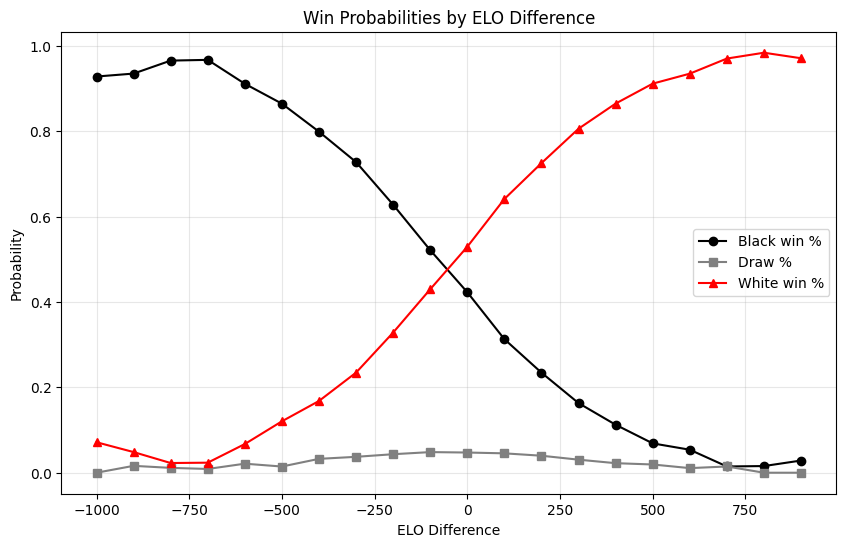

In [6]:
# 3. Win probability by ELO difference
elo_ranges = np.arange(-1000, 1001, 100)
win_probs = []

for i in range(len(elo_ranges)-1):
    mask = (X['elo_diff'] >= elo_ranges[i]) & (X['elo_diff'] < elo_ranges[i+1])
    subset = y[mask]
    if len(subset) > 0:
        white_win_prob = (subset == 1).mean()
        draw_prob = (subset == 0.5).mean()
        black_win_prob = (subset == 0).mean()
        win_probs.append([black_win_prob, draw_prob, white_win_prob])
    else:
        win_probs.append([0, 0, 0])

win_probs = np.array(win_probs)
plt.figure(figsize=(10, 6))
plt.plot(elo_ranges[:-1], win_probs[:, 0], 'o-', label='Black win %', color='black')
plt.plot(elo_ranges[:-1], win_probs[:, 1], 's-', label='Draw %', color='gray')
plt.plot(elo_ranges[:-1], win_probs[:, 2], '^-', label='White win %', color='red')
plt.xlabel('ELO Difference')
plt.ylabel('Probability')
plt.title('Win Probabilities by ELO Difference')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/var/folders/27/7ktdl51577s6mfwmc_b91fyw0000gn/T/ipykernel_19948/1781778724.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(outcome_data, labels=outcome_labels)


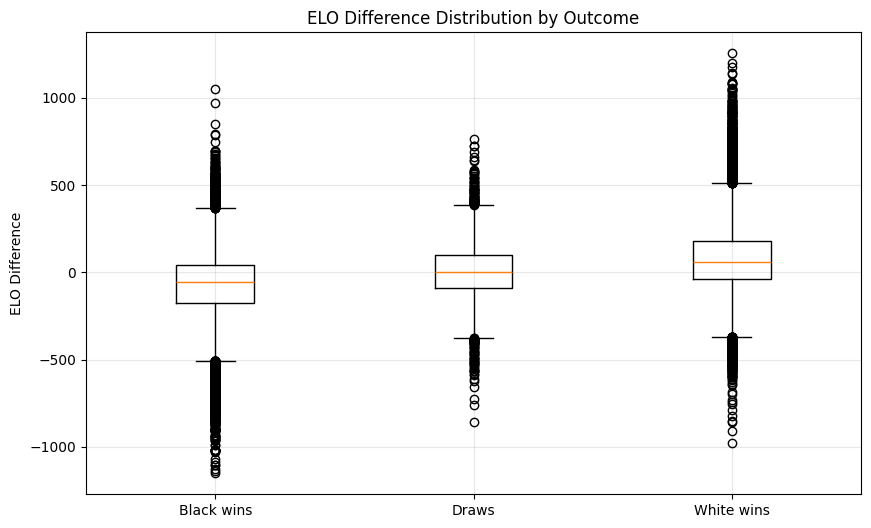

Summary by outcome:
Black wins: 47077 games, mean ELO diff: -75.4, std: 190.9
Draws: 4262 games, mean ELO diff: 5.3, std: 165.5
White wins: 48661 games, mean ELO diff: 80.4, std: 191.4


In [7]:
# 4. Box plot by outcome
outcome_labels = ['Black wins', 'Draws', 'White wins']
outcome_data = [X['elo_diff'][y == 0], X['elo_diff'][y == 0.5], X['elo_diff'][y == 1]]

plt.figure(figsize=(10, 6))
plt.boxplot(outcome_data, labels=outcome_labels)
plt.ylabel('ELO Difference')
plt.title('ELO Difference Distribution by Outcome')
plt.grid(True, alpha=0.3)
plt.show()

# Summary statistics
print("Summary by outcome:")
for outcome, label in [(0, 'Black wins'), (0.5, 'Draws'), (1, 'White wins')]:
    subset = X['elo_diff'][y == outcome]
    print(f"{label}: {len(subset)} games, mean ELO diff: {subset.mean():.1f}, std: {subset.std():.1f}")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1031)

model_baseline = LinearRegression()
model_baseline.fit(X_train, y_train)

y_pred = model_baseline.predict(X_test)

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_baseline)

0.45555775337188986


# XGBoost with Feature Engineering

In [9]:
X = df.drop(columns=['result'])
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1031)

In [17]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

xgb_model = xgb.XGBRegressor(objective='reg:logistic', random_state=1031)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}


In [18]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.4335
MAE: 0.3789


# Improved Feature Engineering

In [20]:
# Add more sophisticated features
def create_advanced_features(df):
    df_new = df.copy()
    
    # Ratio features (often more predictive than raw counts)
    df_new['material_ratio'] = df_new['white_material'] / (df_new['black_material'] + 1)
    df_new['piece_activity'] = df_new['legal_moves'] / (df_new['white_material'] + df_new['black_material'])
    
    # Piece imbalances
    df_new['knight_diff'] = df_new['white_knights'] - df_new['black_knights']
    df_new['bishop_diff'] = df_new['white_bishops'] - df_new['black_bishops']
    df_new['rook_diff'] = df_new['white_rooks'] - df_new['black_rooks']
    df_new['queen_diff'] = df_new['white_queens'] - df_new['black_queens']
    
    # King safety ratio
    df_new['king_safety_diff'] = df_new['black_king_attackers'] - df_new['white_king_attackers']
    
    # ELO-based features
    df_new['avg_elo'] = (df_new['white_elo'] + df_new['black_elo']) / 2
    df_new['elo_diff_normalized'] = df_new['elo_diff'] / df_new['avg_elo']
    
    # Polynomial features for ELO difference
    df_new['elo_diff_squared'] = df_new['elo_diff'] ** 2
    df_new['elo_diff_cubed'] = df_new['elo_diff'] ** 3
    
    return df_new

# Apply feature engineering
df_enhanced = create_advanced_features(df)
X_enhanced = df_enhanced.drop(columns=['result'])
y = df_enhanced['result']

# Ensemble Methods

In [21]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb

# Create ensemble of different models
models = {
    'xgboost': xgb.XGBRegressor(objective='reg:logistic', n_estimators=300, max_depth=6, learning_rate=0.1),
    'lightgbm': lgb.LGBMRegressor(objective='regression', n_estimators=300, max_depth=6, learning_rate=0.1),
    'random_forest': RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42),
    'gradient_boost': GradientBoostingRegressor(n_estimators=200, max_depth=6, learning_rate=0.1),
    'ridge': Ridge(alpha=1.0)
}

# Train all models
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=1031)

predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions[name]))
    print(f"{name} RMSE: {rmse:.4f}")

# Simple ensemble (average)
y_pred_ensemble = np.mean(list(predictions.values()), axis=0)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
print(f"Ensemble RMSE: {rmse_ensemble:.4f}")

xgboost RMSE: 0.4355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 31
[LightGBM] [Info] Start training from score 0.507463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/davidpan/Desktop/repos/chess/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.56497e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
